# Importamos librerías y datasets

In [ ]:
# Importamos las librerías que usaremos
# Algebra lineal 
import numpy as np 

# Procesamiento de datos 
import pandas as pd 

# Visualización de datos 
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline 

# Módulo de estadística 
from numpy import percentile

# Librerías para el procesamiento de texto 
!pip install nltk sklearn joblib
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer

# Lista de palabras vacías 
nltk.download('stopwords')

# Módulo para manejo de string
import string

# Librería para conectar con la API de www.datos.gov.co
!pip install sodapy
from sodapy import Socrata

# Libreraía para preprocesamiento de texto para modelo NPL
from sklearn.feature_extraction.text import CountVectorizer # Vectorización 
from sklearn.feature_extraction.text import TfidfTransformer # Relevancia

# Librería para modelado de NPL
from sklearn.pipeline import Pipeline 
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

# Evaluación del modelo 
from sklearn.metrics import classification_report

In [732]:
def importar_data(path):
    ''' 
    Esta función importa y muestra los datos nulos de los datasets proporcionados, 
    Requiere de la instalación de la librería pandas para funcionar correctamente 

    Parámetros: 
    ------------
    :param path: La ruta donde está alojado el dataset en formato str  

    Return: 
    ------------
    dataset en formato DataFrame 
    '''
    data = pd.read_csv(path)

    data[['title', 'description']].astype(str)

    return data

In [733]:
# Importamos los datos de entrenamiento 
train = importar_data(r'C:\Users\USER\Documents\SOYHENRY\LABS\Proyecto individual de Machine Learning (Henry)\data\properties_colombia_train.csv')

In [734]:
# Importamos los datos de prueba
test = importar_data(r'C:\Users\USER\Documents\SOYHENRY\LABS\Proyecto individual de Machine Learning (Henry)\data\properties_colombia_test.csv')

**Metodología**

Las columnas con menos campos vacíos en ambos dataset son 'title' y 'description', por tanto aplicaremos un modelo de NPL que aproveche toda la información contenida en el texto de los anuncios para identificar patrones en el lenguaje natural que nos permita predecir y clasificar si una propiedad está cara o barata. 

En caso que se desee aplicar otro modelo de clasificación se sugiere emplear NPL del texto para imputar los datos faltantes en las columnas del dataset. 

# **LIMPIEZA DE DATOS**



### 1. Convertimos de USD a COP

In [735]:
def convertir_USD_a_COP(dataset): 
    '''
    Esta función se conecta vía API a una base de datos oficial 
    de Colombia para consultar el tipo de cambio en las fechas de los datos del dataset proporcionado 
    en la columna precios y los convierte de dólares (USD) a pesos colombianos (COP)
    
    Parámetros: 
    --------------
    : param dataset: DataFrame que contenga los datos a analizar 

    Return: 
    --------------
    Nueva columna con "currency" con los nuevos valores de precios, expresados en pesos colombianos (COP)
    '''

    # Buscamos los datos expresados en USD
    filas_en_USD = len(dataset[dataset['currency'] == 'USD'])
    print('Cantidad de filas en USD:', filas_en_USD)

    if filas_en_USD > 0:

        # Extraemos el rango de fecha de los datos en USD
        dataset_copy = dataset.copy()
        # Convertimos la columna con la fecha de referencia en formato datetime 
        dataset_copy['start_date'] = pd.to_datetime(dataset_copy['start_date'])

        # Identificamos el rango de fechas de los datos expresados en USD 
        inicio = dataset_copy['start_date'][dataset_copy['currency'] == 'USD'].unique().min()
        fin = dataset_copy['start_date'][dataset_copy['currency'] == 'USD'].unique().max()

        print('Fecha inicio de los datos expresados en USD:', inicio)
        print('Fecha fin de los datos expresados en USD: ', fin)

        # Realizamos una conexión API con la base de datos oficial de Colombia para visualizar el tipo de cambio USD/COP
        client = Socrata("www.datos.gov.co", None)
        results = client.get("mcec-87by", limit=1000)
        Tipo_Cambio_Colombia = pd.DataFrame.from_records(results)

        # Convertimos la columna de referencia en formato de fecha
        Tipo_Cambio_Colombia['vigenciadesde'] = pd.to_datetime(Tipo_Cambio_Colombia['vigenciadesde'])

        # Filtramos las cotizaciones en el mismo rango de fecha de nuestro dataset y calculamos la media 
        subset_tipo_cambio_Colombia = Tipo_Cambio_Colombia['valor'][(Tipo_Cambio_Colombia['vigenciadesde'] >= inicio) & (Tipo_Cambio_Colombia['vigenciadesde'] <= fin)]
        subset_tipo_cambio_Colombia = (subset_tipo_cambio_Colombia).astype(float)
        Tipo_cambio_COP = subset_tipo_cambio_Colombia.mean()
        Desvío_estándar_COP = subset_tipo_cambio_Colombia.std()

        print('\nTipo de Cambo medio de USD/COP desde 2020-08-08 hasta 2020-10-26 =', round(Tipo_cambio_COP,2))
        print('El desvío estándar del tipo de cambio de USD/COP desde 2020-08-08 hasta 2020-10-26 =', round(Desvío_estándar_COP,2))
        # Admitimos un margen de error de ≈ 1%

        # Convertimos los valores expresados en USD en COP en el dataset de entrenamiento, 
        # ya que en el dataset de test el campo precio está vacío
        # El valor de refrencia es el valor promedio del USD en el rango de fecha de los datos en USD del dataset principal
        precios_en_USD = dataset['price'][dataset['currency'] == 'USD']
        precios_en_COP = precios_en_USD * Tipo_cambio_COP
        dataset['price'][dataset['currency'] == 'USD'] = precios_en_COP

    return 'Antes', precios_en_USD, 'Después', precios_en_COP

In [736]:
convertir_USD_a_COP(train)

Cantidad de filas en USD: 8
Fecha inicio de los datos expresados en USD: 2020-08-08T00:00:00.000000000
Fecha fin de los datos expresados en USD:  2020-10-26T00:00:00.000000000



Tipo de Cambo medio de USD/COP desde 2020-08-08 hasta 2020-10-26 = 3790.54
El desvío estándar del tipo de cambio de USD/COP desde 2020-08-08 hasta 2020-10-26 = 64.83


C:\Users\USER\AppData\Local\Temp\ipykernel_21156\336445081.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['price'][dataset['currency'] == 'USD'] = precios_en_COP


('Antes',
 5902        750000.0
 49196      1960000.0
 56159       850000.0
 56522      1017000.0
 116979     1143711.0
 136236    65999999.0
 137025     3000000.0
 167143     9750000.0
 Name: price, dtype: float64,
 'Después',
 5902      2.842908e+09
 49196     7.429465e+09
 56159     3.221962e+09
 56522     3.854983e+09
 116979    4.335286e+09
 136236    2.501759e+11
 137025    1.137163e+10
 167143    3.695780e+10
 Name: price, dtype: float64)

## 2. Selección y limpieza de columnas que se usarán en el modelo

In [737]:
def crear_columna_text(dataset): 
    '''
    Esta función crea un nuevo dataset solo con las columnas 'title' y 'description' y las concatena para formar 
    una nueva columna llamada texto, además comprueba y elimina datos nulos en las columnas. 

    Parámetros: 
    --------------
    : param dataset: DataFrame de datos de entrenamiento y de prueba que contenga los datos limpiar 

    Return: 
    --------------
    Nuevo dataset con apenas las columnas 'text' y 'price'
    '''    

    # Creamos una nueva columna donde concatenamos título y descripción 
    dataset['text'] = dataset['title'].fillna('').fillna('') + ' ' + dataset['description'].fillna('')

    if dataset is train:

        # Creamos el dataset final
        dataset = dataset[['text', 'price']]

        # Eliminamos todos los campos nulos solo de al dataset de entrenamiento
        dataset = dataset.dropna(how='any', axis=0)
    
    else: 

        # Creamos el dataset final
        dataset = dataset[['text']]

    # Validamos que no existan datos nulos en el dataset de 
    print(dataset.isna().sum())
    print('Cantidad de filas: ',len(dataset))

    return dataset

In [738]:
data_train_text = crear_columna_text(train)
data_test_text = crear_columna_text(test)

text     0
price    0
dtype: int64
Cantidad de filas:  197486
text    0
dtype: int64
Cantidad de filas:  65850


## 3. Eliminamos los outliers del dataset de entrenamiento

In [739]:
def eliminar_outliers(dataset): 
    '''
    Esta función identifica los outliers de la columna 'price del dataset de entrenamiento y crea un nuevo dataset 
    solo con los valores dentro del rango intercuartílico de 10% 

    Parámetros: 
    --------------
    : param dataset: Solo DataFrame de entrenamiento que contenga la columna 'price'

    Return: 
    --------------
    * Percentiles
    * Outliers identificados
    * Observaciones no outliers
    * Porcentaje de outliers
    * Porcentaje de datos descartados 
    * Información de dataset 
    * DataFrame 
    
    '''    
    print('---------- OUTLIERS --------------')
    # Calculamos el rango intercuartílico 
    q10, q90 = percentile(dataset['price'], 10), percentile(dataset['price'], 90)
    rango_intercuartícilo_10 = q90 - q10
    print('\nPercentiles: 10th=%.3f, 90th=%.3f, IQR=%.3f' % (q10, q90, rango_intercuartícilo_10))

    # Calculamos los outliers cutoff
    cut_off = rango_intercuartícilo_10 * 1.5
    lower, upper = q10 - cut_off, q90 + cut_off

    # Identificamos los outliers 
    outliers = [price for price in dataset['price'] if price < lower or price > upper]
    print('\nOutliers identificados: %d' % len(outliers))

    # Eliminamos los outliers
    outliers_removed = [x for x in dataset['price'] if x >= lower and x <= upper]
    print('\nObservaciones no outliers: %d' % len(outliers_removed))

    # Calculamos el porcentaje de outliers
    porc_ouliers = len(outliers)/len(train)
    print('\nPorcentaje de outliers: ', round(porc_ouliers,4), '%')

    # Removemos los outliers y las columnas title y description de nuestro dataset de entrenamiento
    dataset = dataset[((dataset['price'] < lower) | (dataset['price'] > upper) == False)]

    # Chequemos el porcentaje de datos descartados
    datos_descartados = ( 1 - (len(dataset)/(len(train))))*100
    print('\nPorcentaje de datos descartados: ', round(datos_descartados,2), '%')

    print('----------------------------------')

    # Verificamos que los cambios se hayan aplicado correctamente 
    print('\nLa información de los datos de entrenamiento es: ', '\n', dataset.info())

    # Reseteamos los indices 
    dataset.reset_index(inplace=True)
    dataset = dataset[['text', 'price']]

    return dataset

In [740]:
data_train_text = eliminar_outliers(data_train_text)

---------- OUTLIERS --------------

Percentiles: 10th=135000000.000, 90th=1200000000.000, IQR=1065000000.000

Outliers identificados: 5567

Observaciones no outliers: 191919

Porcentaje de outliers:  0.0282 %

Porcentaje de datos descartados:  2.85 %
----------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 191919 entries, 1 to 197548
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   text    191919 non-null  object 
 1   price   191919 non-null  float64
dtypes: float64(1), object(1)
memory usage: 4.4+ MB

La información de los datos de entrenamiento es:  
 None


## 4. Creamos la columna target

In [741]:
def columna_target(dataset): 
    '''
    Esta función crea una columna llamada 'target' con valores binarios 0 y 1, identifican la propiedad como cara o barata, esto es: 
    cara = 1
    barata = 0 

    La manera es que lo calcula es tomando como referencia el precio promedio de la columna precio de los datos de entrenamiento 
    y separa aquellos valores que superen el precio promedio y les asigna el valor 1, aquellos que están por debajo del pecio promedio
    le asigna el valor 0, en formato 'int'. 

    Parámetros: 
    --------------
    : param dataset: Solo DataFrame de entrenamiento que contenga la columna 'price'

    Return: 
    --------------
    Nuevo dataframe con solo la columna 'text' y 'target'
    '''    
    
    # Calculamos el precio promedio de la columna precio
    precio_promedio = dataset['price'].mean()
    print('\nEl precio promedio de las propiedades es: ', round(precio_promedio,2))

    # Creamos la columna target y le colocamos el valor de cero por defecto 
    dataset['target'] = 0


    # Asignamos el alor de 1 a los precios superiores al precio promedio
    for i in range(len(dataset['price'])):
        precio = dataset.loc[i, 'price']
        if precio >= precio_promedio:
            dataset.loc[i, 'target'] = 1

    propiedades_caras = dataset[dataset['target']==1]
    propiedades_baratas = dataset[dataset['target']==0]

    print('Cantidad de Propiedades baratas: ', len(propiedades_baratas))
    print('Cantidad de Propiedades caras: ', len(propiedades_caras))

    dataset['target'].value_counts().plot(kind = 'pie',explode=[0, 0.1],figsize=(6, 6),autopct='%1.1f%%',shadow=True)
    plt.title('Barato vs Caro')
    plt.legend(['Barato', 'Caro'])
    plt.show()

    dataset = dataset[['text', 'target']]

    return dataset


El precio promedio de las propiedades es:  472040822.35
Cantidad de Propiedades baratas:  132480
Cantidad de Propiedades caras:  59439


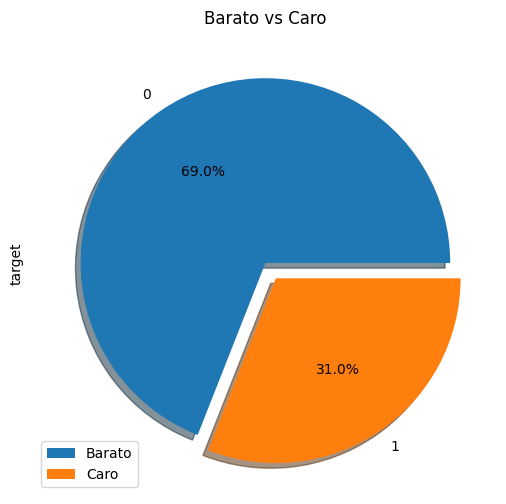

,text,target
0,"APARTAMENTO EN VENTA, BOGOTA-CIUDAD JARDIN NOR...",1
1,Apartamento En Venta En Bogota Bella Suiza Cod...,0
2,SE VENDE LOCAL COMERCIAL EN CABECERA DEL LLANO...,1
3,Apartamento en Venta Ubicado en ITAGUI Codigo ...,0
4,"Venta apartamento en Via Panamericana, Manizal...",0
...,...,...
191914,LM: VENDO APARTAMENTO EN TORRES DE TINTALA VEN...,0
191915,Oficina En Venta En Bogota El Retiro Cod. VREI...,0
191916,Local En Venta En Cali Nueva Tequendama CodVBS...,1
191917,VENTA CASALOTE FONTIBON CASALOTE BIEN UBICADO ...,0


In [742]:
columna_target(data_train_text)

# **EDA**

In [743]:
# Exploramos la cantidad de datos en cada target 
data_train_text.groupby('target').describe()

price                                                        \
           count          mean           std          min          25%   
target                                                                   
0       132480.0  2.504424e+08  1.063373e+08          0.0  165000000.0   
1        59439.0  9.659483e+08  5.028565e+08  472080000.0  600000000.0   

                                                 
                50%           75%           max  
target                                           
0       245000000.0  3.300000e+08  4.720000e+08  
1       780000000.0  1.200000e+09  2.797010e+09

In [744]:
# Creamos una columna que nos indique la londigud de las descripciones 
data_train_text['longitud'] = data_train_text['text'].apply(len)

Text(0.5, 1.0, 'Longitud de texto vs. Cantidad de textos')

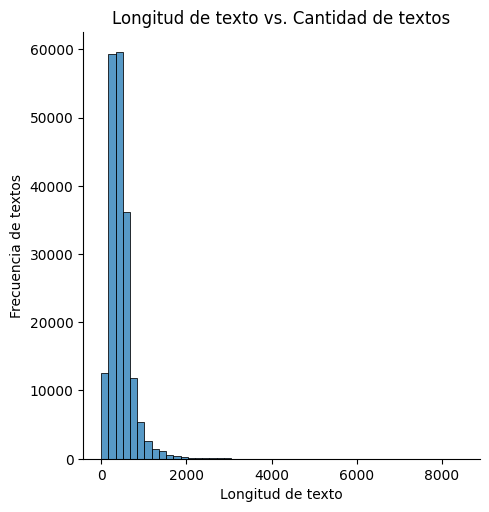

In [745]:
# Visualizamos la distribución de la longitud de las descripciones
sns.displot(data_train_text["longitud"], bins=50)

plt.xlabel('Longitud de texto')
plt.ylabel('Frecuencia de textos')
plt.title('Longitud de texto vs. Cantidad de textos')

In [746]:
# Exploramos las métricas de la longitud de las descripciones de las propiedades 
data_train_text["longitud"].describe()

count    191919.000000
mean        456.110125
std         284.733461
min           2.000000
25%         281.000000
50%         407.000000
75%         553.000000
max        8470.000000
Name: longitud, dtype: float64

In [747]:
# Visualizamos el mensaje con la descripción con mínima longitud
data_train_text[data_train_text["longitud"]==3]['text'].iloc[0]

'✨ ✨'

In [748]:
# Visualizamos el mensaje con la descripción con máxima longitud
data_train_text[data_train_text["longitud"]==8470]['text'].iloc[0]

'Apartamento en Venta en Loma de Los Bernal  Esta propiedad se encuentra ubicada la Loma de los Bernal, un sector tranquilo del barrio Belén, a sus alrededores se encuentra el supermercado EURO, Parque Belén Buena Vista, mirador de los Bernal, Colegio San Francisco Javier, Cerro las tres cruces, Coomeva EPS, Mall gran vía, Parque principal aliadas, Torre Médica las Américas, cuenta con un buen servicio de transporte público, entre ellos la estación "LA PALMA BELÉN" de la nueva línea en construcción del metroplus, lo que hace que el sector sea apetecido por aquellos que quieren vivir en un espacio de calma, naturaleza y armonía.\n\nLa unidad cuenta con vigilancia las 24 horas, shut de basuras, 2 ascensores por torre con planta de emergencia, circuito cerrado de televisión y cámaras. Sus áreas sociales son amplias y variadas, cuenta con 2 sitios de piscina, ambas con piscinas para adultos y para niños, sauna, turco, gimnasio bien dotado, salón social, salón de squash, pista de squite, ju

Comparación de Longitud de texto vs Frecuencia de cada target


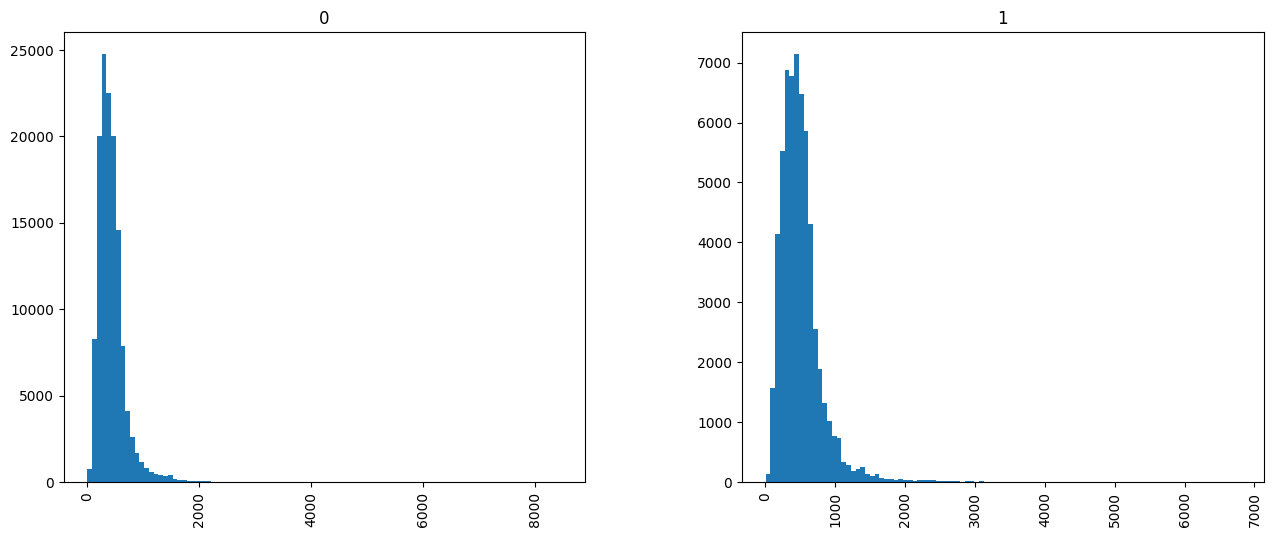

In [749]:
# Visualizamos la distribución de la longitus de las descripciones en cada etiqueta para buscar algún patrón de comportamiento 
data_train_text.hist(column='longitud', bins=100, by='target', figsize=(15,6))
print('Comparación de Longitud de texto vs Frecuencia de cada target')

plt.show()

## Text Preprocessing

In [750]:
# Las stopwords son palabras vacías 
print('Cantidad de stopwords en español: ',len(stopwords.words('spanish')))

Cantidad de stopwords en español:  313


In [751]:
# Caracteres especiales
print('Cantidad de tipos de puntuaciones en español: ',len(string.punctuation))
string.punctuation

Cantidad de tipos de puntuaciones en español:  32


'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [752]:
def re_hiperlinks(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return [re.sub(pattern, ' link ', r) for r in text_list]




In [753]:
# Función para eliminar los signos de puntuación y extraer las keywords del text de cada descripción 
def text_processing(text): 
    '''
    Esta función elimina los signos de puntuación y las palabras vacías del texto 
    
    Parámetros: 
    --------------
    : param text: Texto en formato str 

    Return: 
    --------------
    Lista Texto procesado en formato str
    '''

    # Creamos una lista de palabras del texto sin puntuación
    remove = [c for c in text if c not in string.punctuation]

    # Removemos caracteres especiales
    remove = [re.sub('\W', ' ', r) for r in text]

    # Removemos saltos de linea
    remove = [re.sub('[\n\r]', ' ', r) for r in text]

    # Removemos hipervínculos
    pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    remove = [re.sub(pattern, ' link ', r) for r in text]

    # Unimos todas las palabras de la lista creada en un solo string
    text = ''.join(remove)
    
    # Removemos stopswords, los espacio y devolvemos una lista 
    return  [c.lower() for c in text.split() if c.lower() not in stopwords.words('spanish') and c.isalpha() == True]
    

## **VISUALIZACIÓN**

In [755]:
def bolsa_palabras(dataset): 
    '''
    Esta función se conecta vía API a una base de datos oficial 
    de Colombia para consultar el tipo de cambio en las fechas de los datos del dataset proporcionado 
    en la columna precios y los convierte de dólares (USD) a pesos colombianos (COP)
    
    Parámetros: 
    --------------
    : param dataset: DataFrame que contenga los datos a analizar 

    Return: 
    --------------
    Matriz de dispersión con la cantidad de filas y de vocabulario vectorizado 
    '''
    # Vectorizamos el texto 
    cv_tranformer = CountVectorizer(analyzer=text_processing).fit(dataset['text'])

    # Visualizamos la cantidad de volcabulario de las descripciones
    print('Vocabulario en train: ',len(cv_tranformer.vocabulary_))

    # Creamos la bolsa de palabras de todo el tadaset
    bolsa_palabras = cv_tranformer.transform(dataset['text'])
    bolsa_palabras

    print(f'Forma de la matriz dispersa (filas, vocabulario): {bolsa_palabras.shape}')
    print(f'Monto de ocurrencias diferentes a cero: {bolsa_palabras.nnz}')

    # Medimos la escacez 
    escacez_train = (bolsa_palabras.nnz / (bolsa_palabras.shape[0] * bolsa_palabras.shape[1])) * 100
    print('Escacez train: ', round(escacez_train, 2))

    return cv_tranformer, bolsa_palabras


In [ ]:
cv_tranformer =  bolsa_palabras(data_train_text)

## TF-IDF
Relevancia de los datos

In [758]:
# Ponderamos las palabras vectorizadas con mayor relevancia en el contexto de nuestro dataset
tfidf_transformer = TfidfTransformer().fit(bolsa_palabras(data_train_text))

In [ ]:
# Visualizamos un texto de referencia 
text_0 = data_train_text['text'].iloc[2]

# Transformamos el texto en matriz y visualizamos la frecuencia del vocabulario en el texto de referencia
bow_0 = cv_tranformer.transform([text_0])

In [ ]:
# La asignación de relevancia de las palabras de nuestro texto de referencia
tfidf_0 = tfidf_transformer.transform(bow_0)

In [ ]:
text_tfidf = tfidf_transformer.transform(bolsa_palabras)
print(text_tfidf.shape)

(191799, 75756)


# NLP and Naive Bayes Model

Pipelines

In [ ]:
# Implementación de modelo de NPL en los texto de nuestro dataset de entrenamiento
nb = MultinomialNB().fit(text_tfidf, data_train_text['target'])

In [ ]:
# Predicción de etiqueta de un solo elemento
pred = nb.predict(tfidf_0)[0]
expected = data_train_text['target'][2]

In [ ]:
# Evaluamos para nuestro ejemplo si nuestro modelo se comporta como esperamos 
print(f"Predicción: {pred}\nExpectativa: {expected}")

Predicción: 1
Expectativa: 1


# Evaluación del modelo

In [ ]:
# Corremos nuestro modelo en todo el dataset
all_pred = nb.predict(text_tfidf)

In [ ]:
# Longitud de la matriz de predicción 
all_pred.shape

(191799,)

In [ ]:
# Evaluamos nuestro modelo 
print(classification_report(data_train_text['target'], all_pred))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89    132391
           1       0.83      0.61      0.70     59408

    accuracy                           0.84    191799
   macro avg       0.84      0.78      0.80    191799
weighted avg       0.84      0.84      0.83    191799



# Predicción

In [ ]:
# Asignamos nuestras variables X y y de entrenamiento y prueba
X_train, X_test, y_train = data_train_text['text'], data_train_text['text'], data_train_text['target'] 

Multinomial

In [ ]:
# # Asignamos los parámetros del modelo
pipeline_Multinomial = Pipeline([
    ('bow', CountVectorizer(analyzer=text_processing)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())
])

In [ ]:
pipeline_Multinomial.fit(X_train, y_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_processing at 0x7f9b6b48d4d0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [ ]:
# Hacemos la clasificación de los nuevos datos 
predictions_Multinomial = pipeline_Multinomial.predict(X_test)

In [ ]:
# Creamos el dataset de predicciones
prediction_Multinomial = pd.DataFrame(predictions_Multinomial)
prediction_Multinomial = prediction_Multinomial.rename({0:'pred'}, axis='columns')

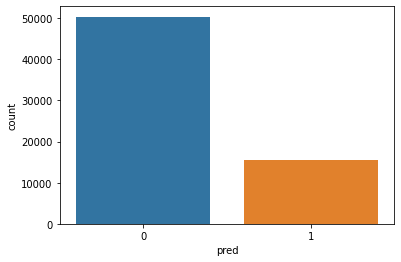

In [ ]:
sns.countplot(x=prediction_Multinomial['pred'])

In [ ]:
# Exportamos el dataset de predicciones según las indicaciones solicitadas
prediction_Multinomial.to_csv('LilaAlvesDC.csv', index=False)

SGDClassifier

In [ ]:
text_clf = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                           alpha=1e-3, random_state=42,
                           max_iter=5, tol=None)),
 ])

In [ ]:
# Indicamos el rango de los parámetros 
parameters = {
     'vect__ngram_range': [(1, 1), (1, 2)],
     'tfidf__use_idf': (True, False),
     'clf__alpha': (1e-2, 1e-3),
 }

In [ ]:
# Le indicamos a la función el rango de parámetros
gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)

In [ ]:
# Le damos algunos datos a la función para que encuente los parámetros más óptimos 
gs_clf = gs_clf.fit(data_train_text.text[:10000], data_train_text.target[:10000])
gs_clf.best_score_

In [ ]:
# Visualizamos los parámetros que nos arroja 
for param_name in sorted(parameters.keys()):
     print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__alpha: 0.001
tfidf__use_idf: True
vect__ngram_range: (1, 1)


In [ ]:
# Definimos los parámetros de nuestro modelo 
text_clf = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', SGDClassifier(loss='squared_hinge', penalty='l1',
                           alpha=0.001, random_state=20,
                           max_iter=5, tol=None)),
 ])

In [ ]:
# Entrenamos nuestro modelo
text_clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, loss='squared_hinge', max_iter=5,
                               penalty='l1', random_state=0, tol=None))])

In [ ]:
# Predicción con modelo SGDClassifier
predictions_SGDClassifier = text_clf.predict(X_test)

In [ ]:
# Creamos el dataframe
prediction_SGDClassifier = pd.DataFrame(predictions_SGDClassifier)

In [ ]:
# Renombramos la columna según lo solicitado
prediction = prediction_SGDClassifier.rename({0:'pred'}, axis='columns')
print(prediction.head())
print(prediction.shape)

   pred
0     1
1     0
2     0
3     1
4     0
(65850, 1)


In [ ]:
# Verificamos la predicción
print('Propiedades baratas: ',len(prediction_SGDClassifier[prediction_SGDClassifier['pred'] == 0]))
print('Propiedades caras: ', len(prediction_SGDClassifier[prediction_SGDClassifier['pred'] == 1]))

Propiedades baratas:  46314
Propiedades caras:  19536


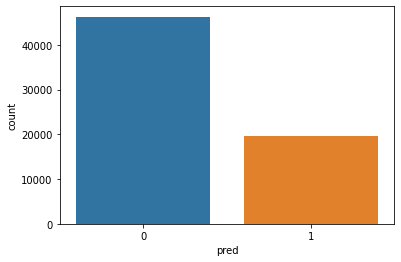

In [ ]:
# Graficamos la clasificación que realizó 
sns.countplot(x=prediction_SGDClassifier['pred'])

In [ ]:
# Exportamos el dataset de predicciones según las indicaciones solicitadas
prediction.to_csv('LilaAlvesDC.csv', index=False)

# CONCLUSIÓN

Nuestro dataset incluye una lista de anuncios de propiedades en Colombia en el año 2020. Nuestro modelo es capaz de identificar el vocabulario de este contexto y asociarlo a una etiqueta que le indicamos, esto es determinar si la propiedad es barata o cara, o que es lo mismo, si el precio está por encima o por debajo de la media. 

Analizando apenas el texto de los anuncios nuestro modelo clasifica con 75% de probabilidade de acierto. 

En una segunda etapa, para mejorar estos resultados podríamos ajustar la metodología segmentando los tipos de propiedades y analizando sus grupos de manera aislada, además se podría incluir un diccionario indicando el vocabulario que consideramos que tiene mayor relevancia o correlación para determinar si una propiedad es cara o barata. 